In [1]:
import re
import os
import nltk
import spacy
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from operator import itemgetter
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, GlobalMaxPooling1D,Flatten, Conv1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

In [2]:
dataset_training = pd.read_csv("training.csv")
dataset_testing = pd.read_csv("test.csv")

In [3]:
dataset = pd.concat([dataset_training, dataset_testing])

In [4]:
dataset.head(1)

,Unnamed: 0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
0,0.0,0.0,1.467811e+09,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dataset = dataset.iloc[:,[1, 6]]

In [6]:
dataset = dataset.rename(columns={"0": "sentiment", "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D": "tweet"})

In [7]:
dataset.dropna(inplace=True)

In [8]:
dataset["sentiment"] = dataset["sentiment"].astype(int)

In [9]:
dataset["sentiment"] = dataset["sentiment"].replace(4, 1)

In [10]:
dataset.head()

,sentiment,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


(array([799999.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 800000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

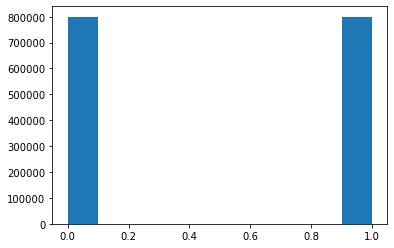

In [12]:
import matplotlib.pyplot as plt
plt.hist(dataset["sentiment"].values)

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   tweet      1599999 non-null  object
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


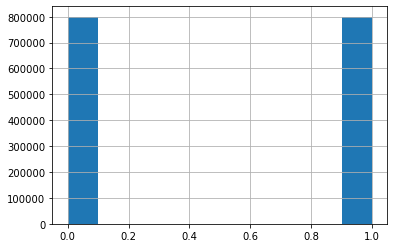

In [13]:
dataset["sentiment"].hist()

In [14]:
len(dataset[dataset.sentiment == 0]), len(dataset[dataset.sentiment == 1])

(799999, 800000)

In [15]:
dataset.isnull().any()

sentiment    False
tweet        False
dtype: bool

In [16]:
dataset.tail()

,sentiment,tweet
1599994,1,Just woke up. Having no school is the best fee...
1599995,1,TheWDB.com - Very cool to hear old Walt interv...
1599996,1,Are you ready for your MoJo Makeover? Ask me f...
1599997,1,Happy 38th Birthday to my boo of alll time!!! ...
1599998,1,happy #charitytuesday @theNSPCC @SparksCharity...


In [17]:
X = dataset["tweet"]
y = dataset["sentiment"]

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [19]:
vocabulary_size = len(tokenizer.word_index) + 1

In [20]:
sequences = tokenizer.texts_to_sequences(X)

In [21]:
len(sequences) == len(X)

True

In [22]:
sequences[0]

[8,
 818,
 17,
 111,
 69,
 565,
 193,
 536,
 126,
 2097,
 9,
 6,
 299,
 551,
 85,
 4,
 2399,
 149,
 40,
 273,
 1170]

In [23]:
for i in range(1, len(sequences)):
    max_length = len(sequences[0])
    
    current_length = len(sequences[i])
    if current_length > max_length:
        max_length = current_length

In [24]:
max_length

21

In [25]:
X = pad_sequences(sequences, padding='post', maxlen=max_length)

In [26]:
labels = to_categorical(np.asarray(y))

In [27]:
len(dataset["tweet"])

1599999

In [28]:
dataset["tweet"].shape[0] == len(X) == labels.shape[0]

True

In [29]:
embedding_index = {}

f = open('glove.6B.100d.txt')
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
    except:
        import pdb; pdb.set_trace()
f.close()

In [30]:
embedding_index['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [31]:
embedding_dim = 100

embedding_matrix = np.zeros((vocabulary_size,embedding_dim))
#embedding_matrix = np.zeros((len(word_index),embedding_dim)

In [32]:
for word,i in tokenizer.word_index.items():
    try:
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        print(f'{word} - {i}')

In [33]:
embedding_matrix.shape, len(embedding_index)

((690960, 100), 400000)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2)

In [35]:
embedding_dim = 100

model = Sequential()
embedding_layer = Embedding(vocabulary_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=21,
                            trainable=False)

model.add(embedding_layer)
model.add(LSTM(256, dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 100)           69096000  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 69,462,082
Trainable params: 366,082
Non-trainable params: 69,096,000
_________________________________________________________________


In [38]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=256, epochs=30)

Epoch 1/30
4000/4000 [==============================] - 18s 4ms/step - loss: 0.4975 - acc: 0.7557 - val_loss: 0.4529 - val_acc: 0.7893
Epoch 2/30
4000/4000 [==============================] - 18s 4ms/step - loss: 0.4446 - acc: 0.7905 - val_loss: 0.4218 - val_acc: 0.8046
Epoch 3/30
4000/4000 [==============================] - 18s 4ms/step - loss: 0.4230 - acc: 0.8031 - val_loss: 0.4210 - val_acc: 0.8080
Epoch 4/30
4000/4000 [==============================] - 18s 4ms/step - loss: 0.4097 - acc: 0.8111 - val_loss: 0.4049 - val_acc: 0.8147
Epoch 5/30
4000/4000 [==============================] - 18s 4ms/step - loss: 0.3997 - acc: 0.8166 - val_loss: 0.4015 - val_acc: 0.8163
Epoch 6/30
4000/4000 [==============================] - 18s 4ms/step - loss: 0.3922 - acc: 0.8209 - val_loss: 0.3989 - val_acc: 0.8190
Epoch 7/30
4000/4000 [==============================] - 18s 4ms/step - loss: 0.3864 - acc: 0.8237 - val_loss: 0.3960 - val_acc: 0.8200
Epoch 8/30
4000/4000 [==============================] -

In [39]:
loss, accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 19s 2ms/step - loss: 0.4036 - acc: 0.8209


In [40]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

loss = history.history['loss']
validation_loss = history.history['val_loss']

In [41]:
import matplotlib.pyplot as plt

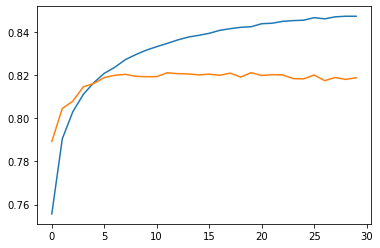

In [42]:
plt.plot(range(len(accuracy)), accuracy)
plt.plot(range(len(accuracy)), validation_accuracy)

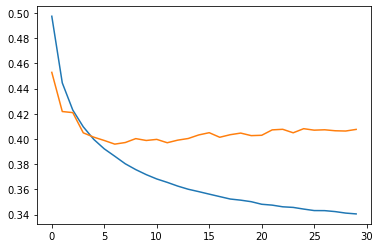

In [43]:
plt.plot(range(len(accuracy)), loss)
plt.plot(range(len(accuracy)), validation_loss)

In [44]:
X_train.shape

(1279999, 21)

In [81]:
example = ["Hey I'm feeling lucky today"]
#example = ["I'm really angry"]

sequnce_example = tokenizer.texts_to_sequences(example)
padded_sequence_example = pad_sequences(sequnce_example, padding='post', maxlen=max_length)

In [82]:
padded_sequence_example

array([[157,  19, 198, 569,  40,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [83]:
results = model.predict(padded_sequence_example)

In [84]:
indice = np.argmax(results[0])

In [86]:
indice

1

In [85]:
results[0][indice]

0.98470956

In [59]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [64]:
model.save("sentiment_model_lstm_v1")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: sentiment_model_lstm_v1/assets
